In [4]:
import tensorflow as tf
import numpy as np
from utilities.dataset_factory import DatasetFactory 
from utilities.visualization import Visualizer
import keras
from keras import Model
from keras import optimizers
from model.SiameseModel import SiameseModel
from distance.DistanceLayer import DistanceLayer
from utilities.data_reader import DataReader
from utilities.mapping import Mapper
from distance.EuclideanDistance import EuclideanDistance
from metrics.Product import Product
from utilities.test_products_generator import TestProductsGenerator
from metrics.Metrics import Metrics
from livelossplot import PlotLossesKeras
from model.model_factory import ModelFactory

# Hyperparameters

In [5]:
image_size = (224, 224)
epochs = 10
batch_size = 16
margin = 0.5 # margin for triplet loss
training_triplets = 50
validation_triplets = 10
training_path = r".\data\FruitRecognition\Training"
validation_path = r".\data\FruitRecognition\Validation"

# Creating training dataset from generator 

In [6]:
training_dataset = DatasetFactory.build_dataset(ds_path=training_path,
                                                image_size=image_size,
                                                batch_size=batch_size,
                                                max_iterations=training_triplets,
                                                method="triplet_loss")
print(training_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None))>


# Creating validation dataset from generator

In [7]:
validation_dataset = DatasetFactory.build_dataset(ds_path=validation_path, 
                                                  image_size=image_size,
                                                  batch_size=batch_size,
                                                  max_iterations=validation_triplets,
                                                  method="triplet_loss")
print(validation_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None))>


 # Visual verification of images from datasets

(224, 224, 3)


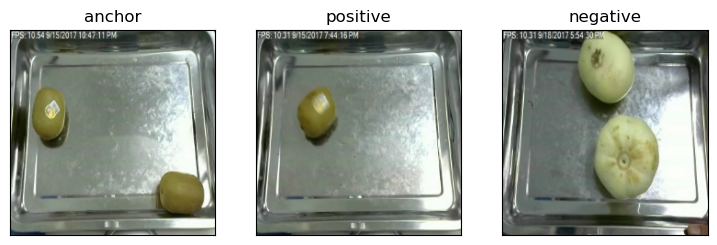

In [8]:
triplet_training = next(iter(training_dataset))

anchor_img = np.asarray(triplet_training[0][0]).astype('float32')
positive_img = np.asarray(triplet_training[1][0]).astype('float32')
negative_img = np.asarray(triplet_training[2][0]).astype('float32')

Visualizer.visualize(**{"anchor": anchor_img, "positive" : positive_img, "negative" : negative_img})
print(anchor_img.shape)

(224, 224, 3)


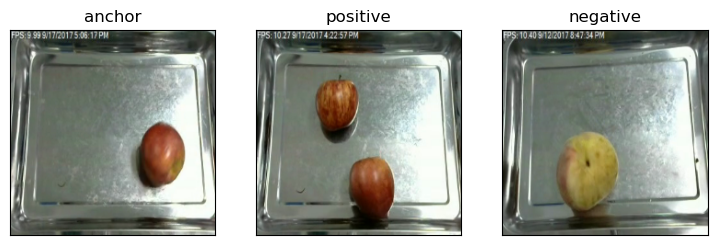

In [9]:
triplet_validation = next(iter(validation_dataset))

anchor_img = np.asarray(triplet_validation[0][0]).astype('float32')
positive_img = np.asarray(triplet_validation[1][0]).astype('float32')
negative_img = np.asarray(triplet_validation[2][0]).astype('float32')
Visualizer.visualize(**{"anchor": anchor_img, "positive" : positive_img, "negative" : negative_img})
print(anchor_img.shape)

# Load model (Transfer learning)

In [10]:
from keras.src.applications.vgg16 import VGG16
modelVGG = VGG16(weights='imagenet', include_top=False)

# Creating siamese model

In [11]:
input_layer = keras.layers.Input(image_size + (3,))
x = modelVGG(input_layer)
# x = keras.layers.BatchNormalization()(input_layer)
# x = keras.layers.Conv2D(16, (5,5), activation="tanh")(x)  # ilość elementów filtra, rozmiar filtra
# x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
# x = keras.layers.Conv2D(32, (5,5), activation="tanh")(x)
# x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
# x = keras.layers.Flatten()(x)

# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Dense(10, activation="tanh")(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(32, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(16, activation="relu")(x)
x = keras.layers.Lambda(lambda param: tf.math.l2_normalize(param, axis=1))(x)
embedding_model = keras.Model(input_layer, x)

# Adding merge layer and creating output layer

In [12]:
anchor_input = keras.layers.Input(name="anchor", shape=image_size + (3,))
positive_input = keras.layers.Input(name="positive", shape=image_size + (3,))
negative_input = keras.layers.Input(name="negative", shape=image_size + (3,))

distances = DistanceLayer()(
    embedding_model(anchor_input),
    embedding_model(positive_input),
    embedding_model(negative_input),
)

siamese_model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances)

# Freezing weights on trained layers

In [13]:
for layer in modelVGG.layers:
    layer.trainable = False

# Creating callbacks

In [14]:
# Wartosc parametru patience musi byc dostosowana do ilosci epok
# Moja estymata to n_epok >= patience * 2
monitor_val_loss = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15) 
# Wartosc patience musi byc mniejsza niz w EarlyStopping
# gdyz najpierw chcemy przetestowac zmiane learning rate w kolejnych epokach
# a dopiero wtedy przerwac trening jesli nie dalo to efektow
reduce_learning_rate = keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                         factor=0.1,
                                                         patience=10,
                                                         min_lr=0.001)

# Compilation of our model and summary

In [15]:
siamese_network = SiameseModel(siamese_model, margin=margin)
siamese_network.compile(optimizer=optimizers.Adam(0.0001), metrics=['accuracy'])
siamese_network.summary()

Model: "siamese_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_3 (Functional)       │ ?                      │    15,518,192 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,518,192 (59.20 MB)

 Trainable params: 803,440 (3.06 MB)

 Non-trainable params: 14,714,752 (56.13 MB)

# Training 

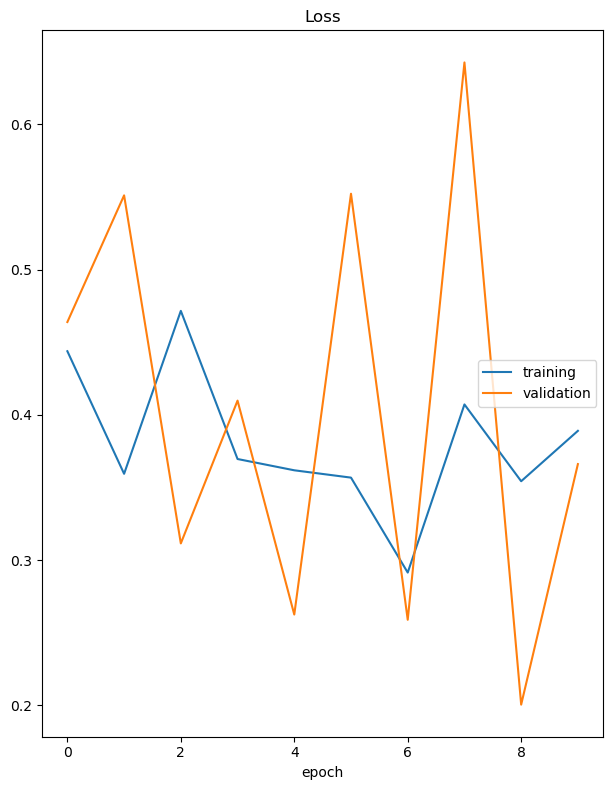

Loss
	training         	 (min:    0.291, max:    0.472, cur:    0.389)
	validation       	 (min:    0.201, max:    0.643, cur:    0.366)
4/4 ━━━━━━━━━━━━━━━━━━━━ 31s 8s/step - loss: 0.3729 - val_loss: 0.3661


In [16]:
siamese_network.fit(training_dataset, epochs=epochs, batch_size=batch_size, validation_data=validation_dataset, callbacks=[PlotLossesKeras(), monitor_val_loss])

# Saving trained model weights

In [17]:
# siamese_network.save_weights('trained_models/VGG16_plus_dense_64_16_triplet.weights.h5')
# embedding_model = ModelFactory.create_model(image_size, modelVGG, "triplet_loss", margin)
# embedding_model.summary()
# embedding_model.load_weights('trained_models/VGG16_plus_dense_64_16_triplet.weights.h5')
# embedding_model.get_layer()

# Loading all the representatives of product types 

In [18]:
path = r".\data\FruitRecognition\representatives\represent_5"
products_paths = DataReader.read_types_of_products(path)
products_dictionary = DataReader.generate_images_classes_dict(products_paths)
k, v = products_dictionary.items().__iter__().__next__()
print(k)
print(v)

.\data\FruitRecognition\representatives\represent_5\Apple A
['.\\data\\FruitRecognition\\representatives\\represent_5\\Apple A\\Apple 132.png', '.\\data\\FruitRecognition\\representatives\\represent_5\\Apple A\\Apple 153.png', '.\\data\\FruitRecognition\\representatives\\represent_5\\Apple A\\Apple 488.png', '.\\data\\FruitRecognition\\representatives\\represent_5\\Apple A\\Apple 623.png', '.\\data\\FruitRecognition\\representatives\\represent_5\\Apple A\\Apple 691.png']


# Mapping representatives and parsing into Product objects

In [19]:
representatives = {}
mapper = Mapper(image_size)
for label, products in products_dictionary.items():
    lab = label.rsplit('\\', 1)[1]
    representatives[lab] = []
    for product in products:
        rep = Product()
        rep.label, rep.image = mapper.map_single_product(lab, product)
        rep.image_path = product
        representatives[lab].append(rep)
first_product = next(iter(representatives))
print(representatives[first_product][4].label, representatives[first_product][4].image_path, representatives[first_product][4].image)

Apple A .\data\FruitRecognition\representatives\represent_5\Apple A\Apple 691.png tf.Tensor(
[[[0.55520713 0.6210972  0.6250188 ]
  [0.55049396 0.6133454  0.61726695]
  [0.5713773  0.63750875 0.6414303 ]
  ...
  [0.8193103  0.9095064  0.91286784]
  [0.8237183  0.915315   0.9215662 ]
  [0.82566535 0.919783   0.92370456]]

 [[0.5550983  0.6181935  0.6231993 ]
  [0.5596476  0.62079585 0.6265031 ]
  [0.545477   0.6057598  0.610638  ]
  ...
  [0.814666   0.9093263  0.910073  ]
  [0.8108131  0.9065552  0.90869105]
  [0.8074931  0.9051821  0.907318  ]]

 [[0.57451355 0.62549394 0.63417745]
  [0.5738808  0.62486124 0.6356693 ]
  [0.6729217  0.7239021  0.7319191 ]
  ...
  [0.8053586  0.91824496 0.9085274 ]
  [0.8100716  0.92380834 0.91595393]
  [0.8106793  0.9234595  0.91656166]]

 ...

 [[0.9686275  0.9960785  0.9686275 ]
  [0.9686275  0.9960785  0.9686275 ]
  [0.9686275  0.9960785  0.9686275 ]
  ...
  [0.4666667  0.5058824  0.45098042]
  [0.4666667  0.5058824  0.45098042]
  [0.46358538 0.4997

# Reshaping the images so as they would fit into out model

In [20]:
for label, products in representatives.items():
    for product in products:
        product.image = tf.reshape(product.image, shape=(1,) + image_size + (3,))
first_product = next(iter(representatives))
print(representatives[first_product][4].image)

tf.Tensor(
[[[[0.55520713 0.6210972  0.6250188 ]
   [0.55049396 0.6133454  0.61726695]
   [0.5713773  0.63750875 0.6414303 ]
   ...
   [0.8193103  0.9095064  0.91286784]
   [0.8237183  0.915315   0.9215662 ]
   [0.82566535 0.919783   0.92370456]]

  [[0.5550983  0.6181935  0.6231993 ]
   [0.5596476  0.62079585 0.6265031 ]
   [0.545477   0.6057598  0.610638  ]
   ...
   [0.814666   0.9093263  0.910073  ]
   [0.8108131  0.9065552  0.90869105]
   [0.8074931  0.9051821  0.907318  ]]

  [[0.57451355 0.62549394 0.63417745]
   [0.5738808  0.62486124 0.6356693 ]
   [0.6729217  0.7239021  0.7319191 ]
   ...
   [0.8053586  0.91824496 0.9085274 ]
   [0.8100716  0.92380834 0.91595393]
   [0.8106793  0.9234595  0.91656166]]

  ...

  [[0.9686275  0.9960785  0.9686275 ]
   [0.9686275  0.9960785  0.9686275 ]
   [0.9686275  0.9960785  0.9686275 ]
   ...
   [0.4666667  0.5058824  0.45098042]
   [0.4666667  0.5058824  0.45098042]
   [0.46358538 0.49971974 0.44481778]]

  [[0.9686275  0.9960785  0.968627

# Evaluating embeddings for all representatives

In [21]:
for label, products in representatives.items():
    for product in products:
        product.embedding = np.asarray(embedding_model(product.image)).astype('float32')
first_product = next(iter(representatives))
print(representatives[first_product][4].embedding)

[[0.         0.20487684 0.13084538 0.29734215 0.         0.9233053
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]]


# Creating a generator for test images

In [22]:
test_path = r".\data\FruitRecognition\Test"
test_generator = TestProductsGenerator(test_path)

# Calculating the overall efficiency of the model based on the testing dataset 

In [24]:
efficiency_sum = 0
test_length = 0
mapper = Mapper(image_size)

# for l, p in test_generator.get_next_element():
for i in range(100):
    l, p = next(iter(test_generator.get_next_element()))
    label, image = mapper.map_single_product(l, p)
    label = label.rsplit('\\', 1)[1]
    image_path = p
    image = tf.reshape(image, shape=(1,) + image_size + (3,))
    embedding = np.asarray(embedding_model(image)).astype('float32')
    distances = np.zeros(len(representatives.keys()))
    labels = []
    j = 0
    for label, products in representatives.items():
        sum = 0
        for product in products:
            sum += EuclideanDistance.calculate_distance((embedding, product.embedding))
        mean = sum / len(products)
        distances[j] = mean
        labels.append(label)
    top5_dist, top5_labels = Metrics.find_top_5(distances,labels)
    efficiency_sum += Metrics.calculate_efficiency(label, top5_labels) 
    test_length += 1
overall_efficiency = efficiency_sum / test_length
print(overall_efficiency)
print(test_length)

0.0
100
